In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# manually define building names
buildingnames = ['YUAG',
                 'Berkeley',
                 'Hopper',
                 '304Elm',
                 'Davenport',
                 '38HH',
                 '320Temple',
                 '53Wall',
                 'Sprague',
                 'Malone',
                 'Trumbull',
                 '17HH']

# Consumption Data Processing

In [3]:
# read from csv into a new dataframe
raw = pd.read_csv('energy_raw.csv',index_col=0,na_values=['#########'])

# reindex by appropriate datetime
raw.index = pd.to_datetime(raw.index,format='%a %m/%d/%y %H:00')

# add missing rows by full reindexing
correct_dt = pd.DatetimeIndex(start='2018-01-01 00:00:00',end='2018-07-27 23:00:00',freq='h')
raw = raw.reindex(index=correct_dt)

# remove built-in demand values, which tend to be bugged
raw = raw.drop(raw.columns[np.arange(0,len(buildingnames)*2,2)], axis=1)

# rename columns accordingly
raw.columns = buildingnames

In [4]:
# remove impossible outliers indicated by negative percent change
raw_head = raw.iloc[0]
raw = raw.where(raw.pct_change(limit=1)>0)
raw.iloc[0] = raw_head

# not currently implemented method to find outliers 
# tau = 0.0005 * (raw.max()-raw.min())
# raw = raw.where(raw.pct_change(limit=1)<tau)


In [5]:
# interpolate gaps in consumption data 6 hours and shorter
for k in raw.columns:
    raw[k] = fn.limited_impute(raw[k],6)

# Demand Data Processing

YUAG          86
Berkeley       0
Hopper         0
304Elm        86
Davenport    903
38HH           0
320Temple     89
53Wall        80
Sprague        0
Malone        79
Trumbull      80
17HH          81
dtype: int64


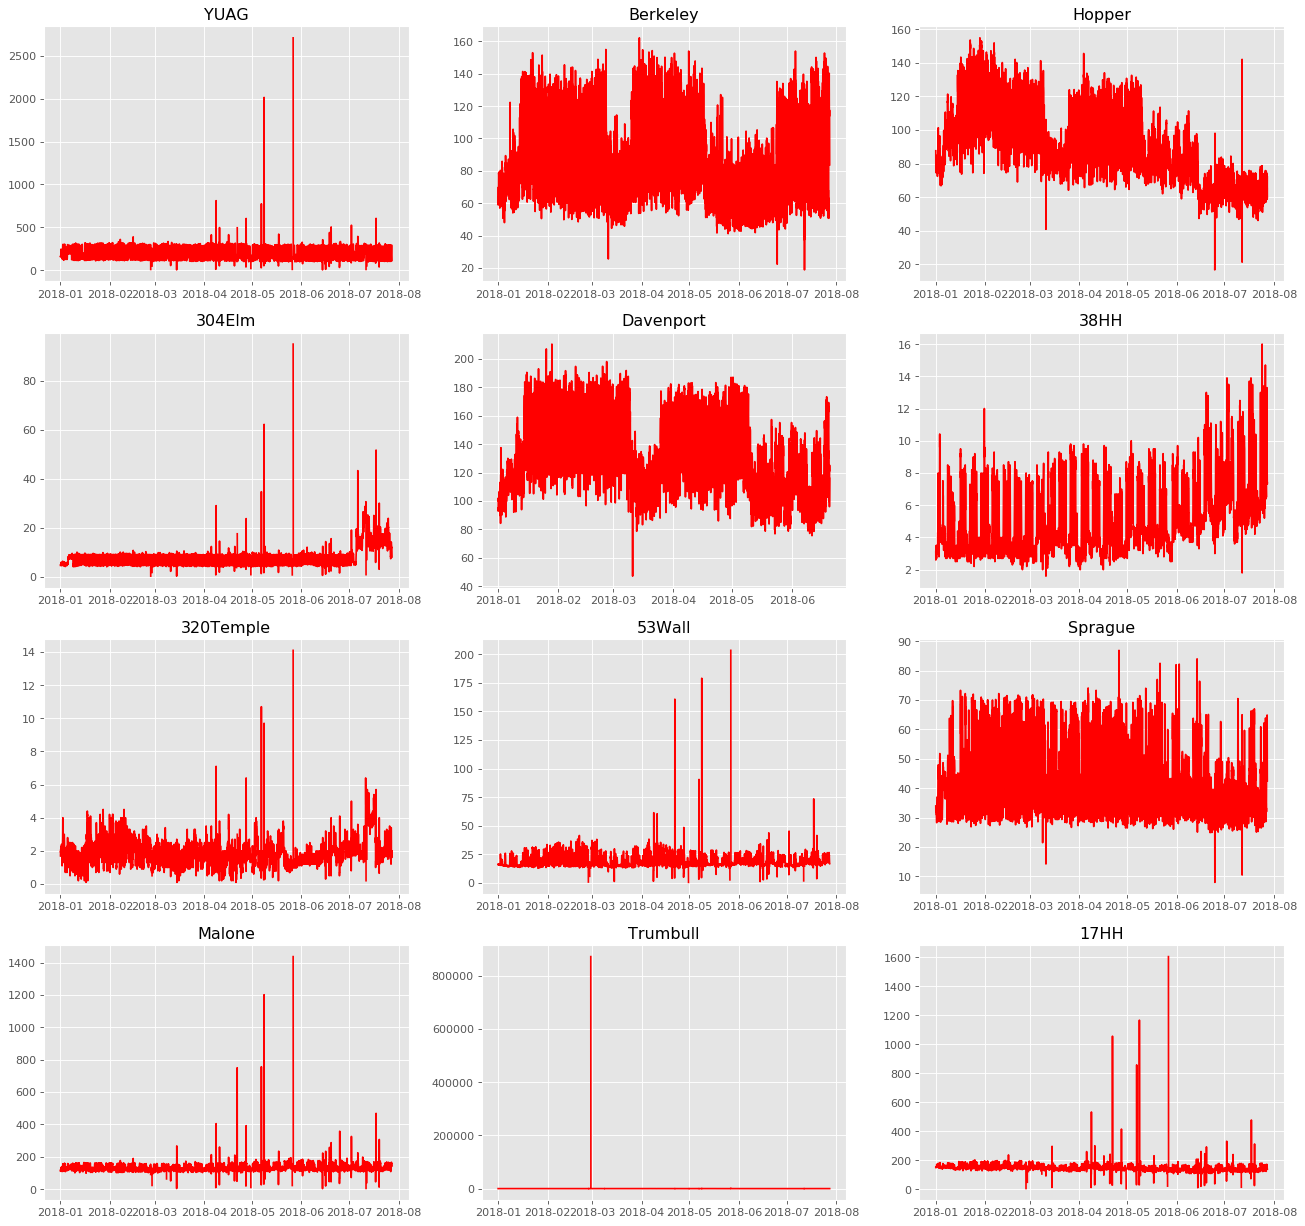

In [6]:
# creates a new dataframe for the demand values, drops the first row
demand = raw.diff().drop(raw.index[0])

# saves head to replace later
demand_head = demand.iloc[0:4]

errors = demand.isnull().sum()
print(errors)

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

YUAG          4
Berkeley      0
Hopper        4
304Elm       10
Davenport     2
38HH          1
320Temple     6
53Wall        9
Sprague       4
Malone       36
Trumbull      1
17HH         43
dtype: int64


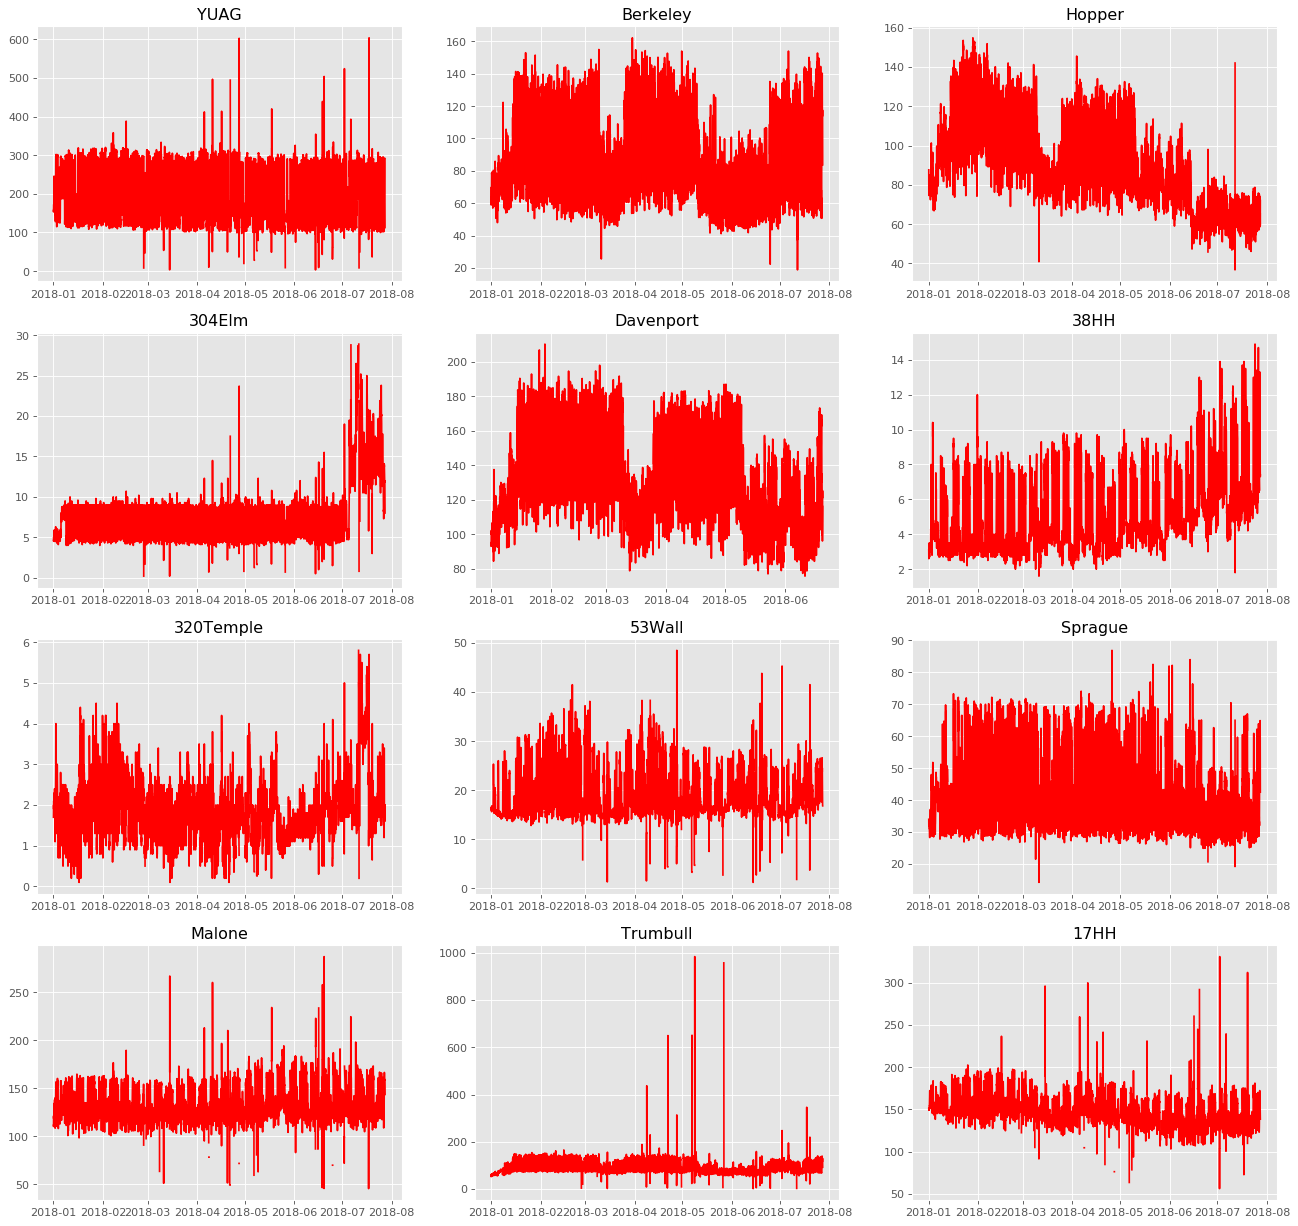

In [7]:
# Remove huge statistical outliers
demand = demand.where(demand > demand.median() - 2.5*demand.std())
demand = demand.where(demand < demand.median() + 5*demand.std())

new_errors = demand.isnull().sum() - errors
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

YUAG         0
Berkeley     0
Hopper       0
304Elm       0
Davenport    0
38HH         0
320Temple    0
53Wall       0
Sprague      0
Malone       0
Trumbull     0
17HH         0
dtype: int64


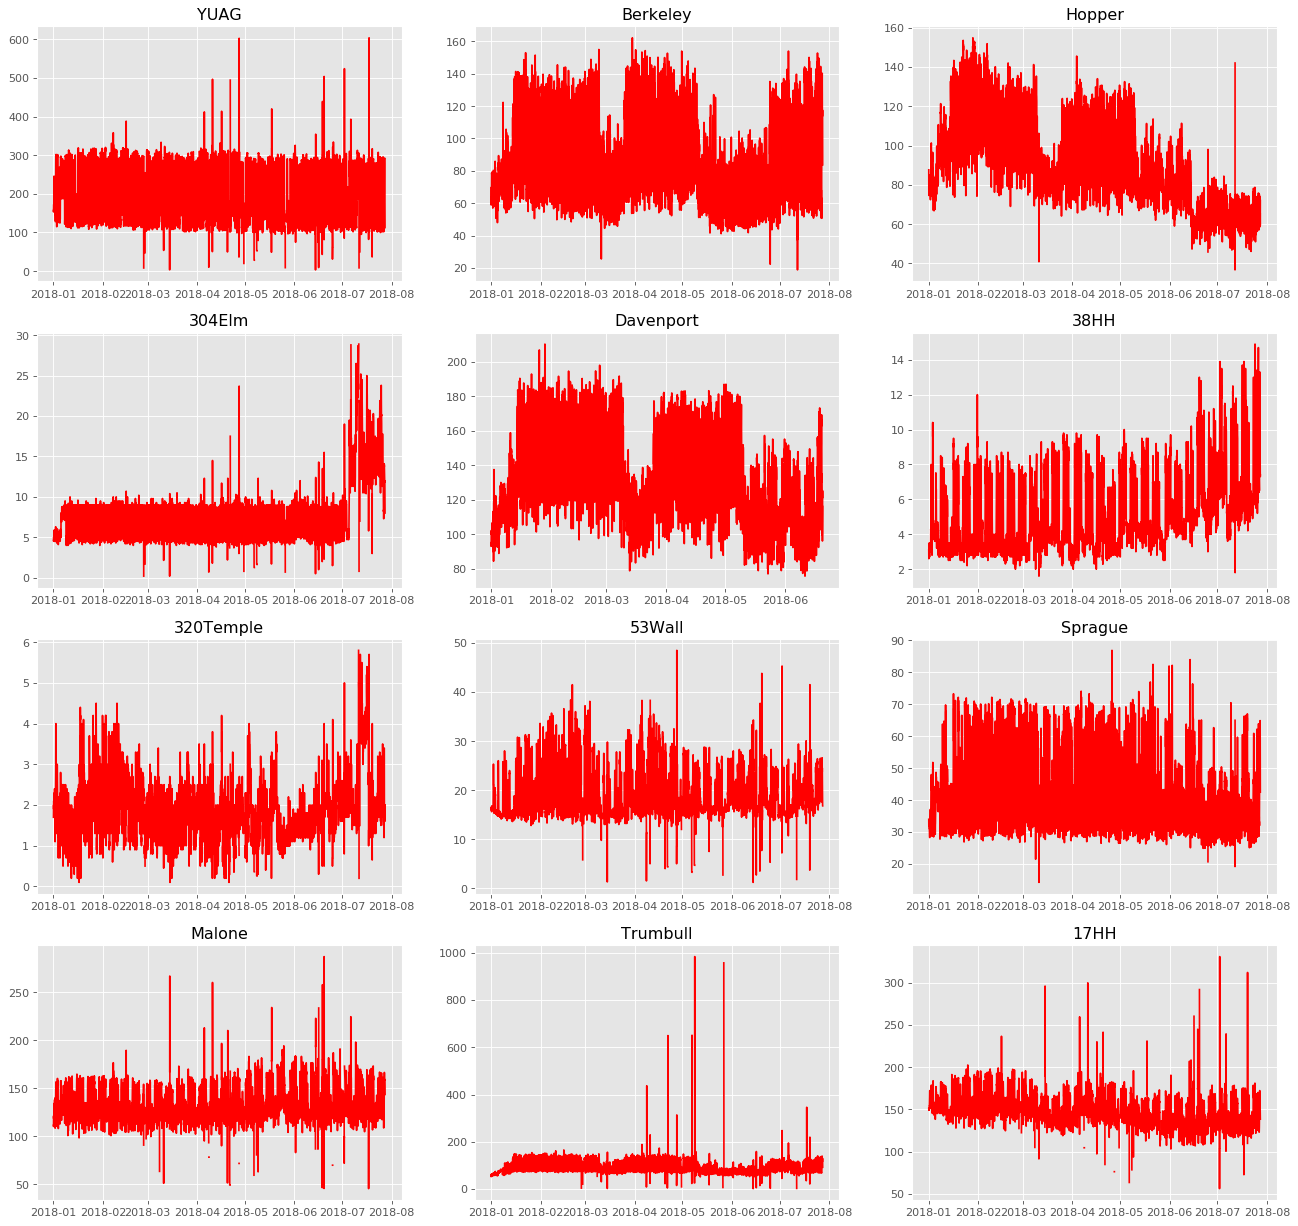

In [8]:
# iterative (SLOW) method to remove single spikes, unsure how helpful it is

# for k in demand.columns:
#     for i in range(len(demand)-1):
#         if (abs(demand.pct_change()[k][i]) > 0.5) & (abs(demand.pct_change()[k][i+1]) > 0.5):
#             demand[k][i] = np.NaN

            
new_errors = demand.isnull().sum() - errors
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

YUAG          45
Berkeley      40
Hopper         5
304Elm       129
Davenport     18
38HH          35
320Temple    209
53Wall        62
Sprague       33
Malone        33
Trumbull      77
17HH          21
dtype: int64


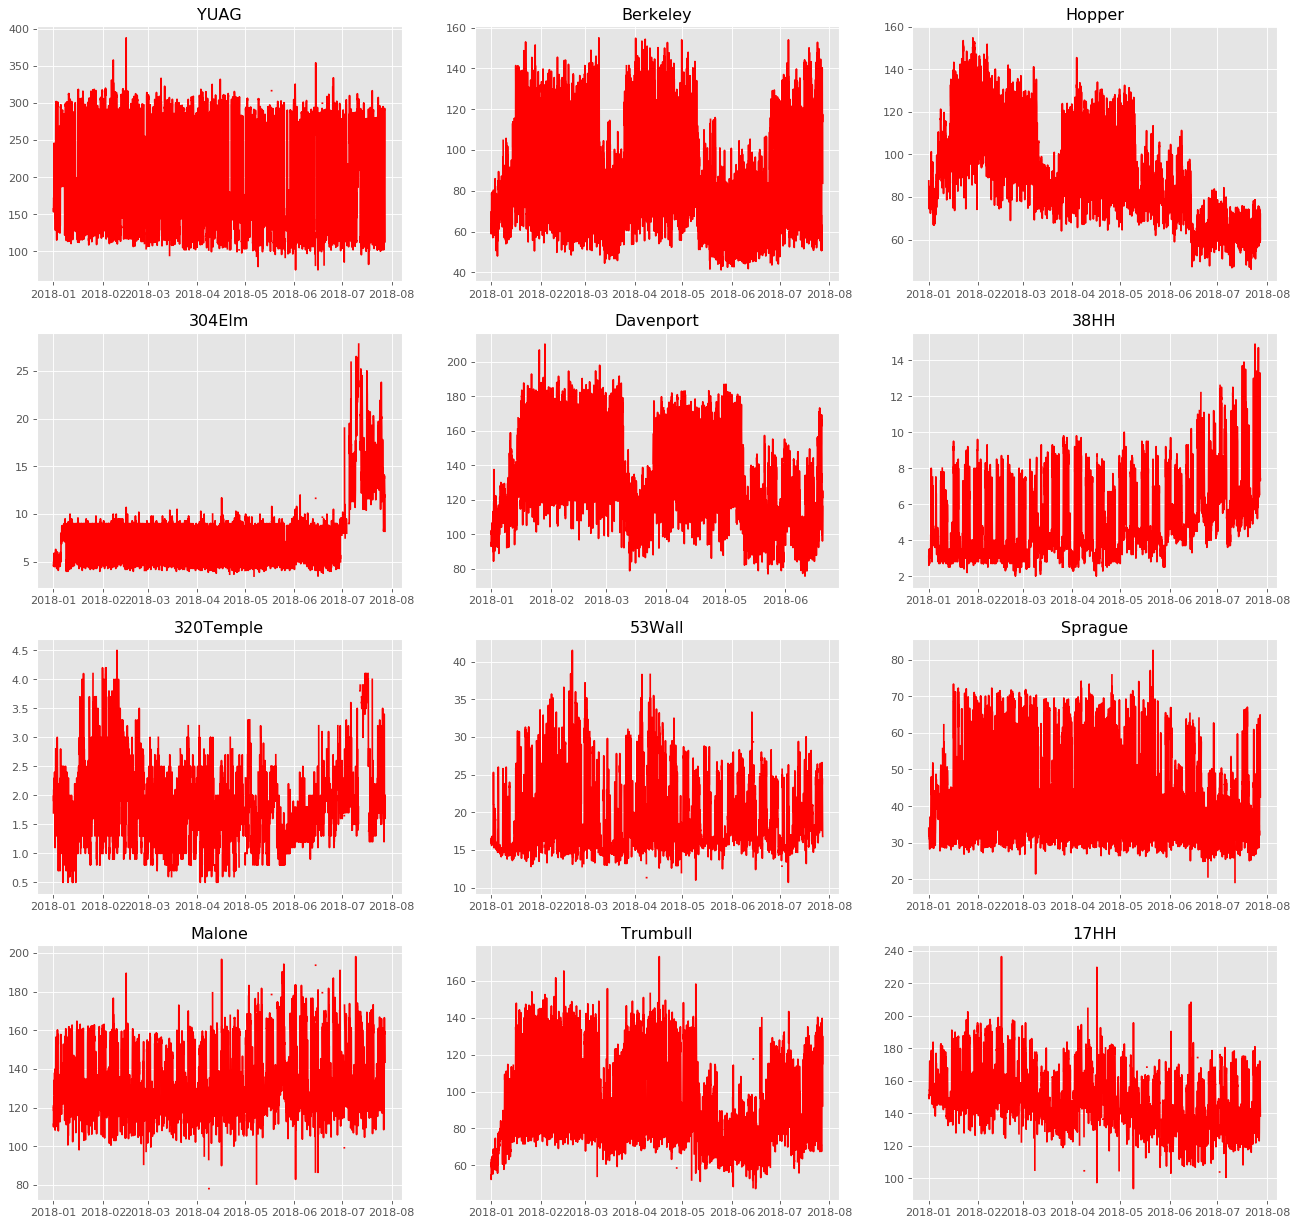

In [9]:
# remove errors by rolling min and max within 10-day chunks
chunk_size = 360
i=0

while i < len(demand):
    end = i+chunk_size
    if end > len(demand): end = len(demand)
    demand[i:end].where(demand[i:end] > demand[i:end].rolling(18).min().median()*0.7, inplace=True)
    demand[i:end].where(demand[i:end] < demand[i:end].rolling(18).max().median()*1.3, inplace=True)
    i = i+chunk_size


new_errors = demand.isnull().sum() - errors
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

# Imputation

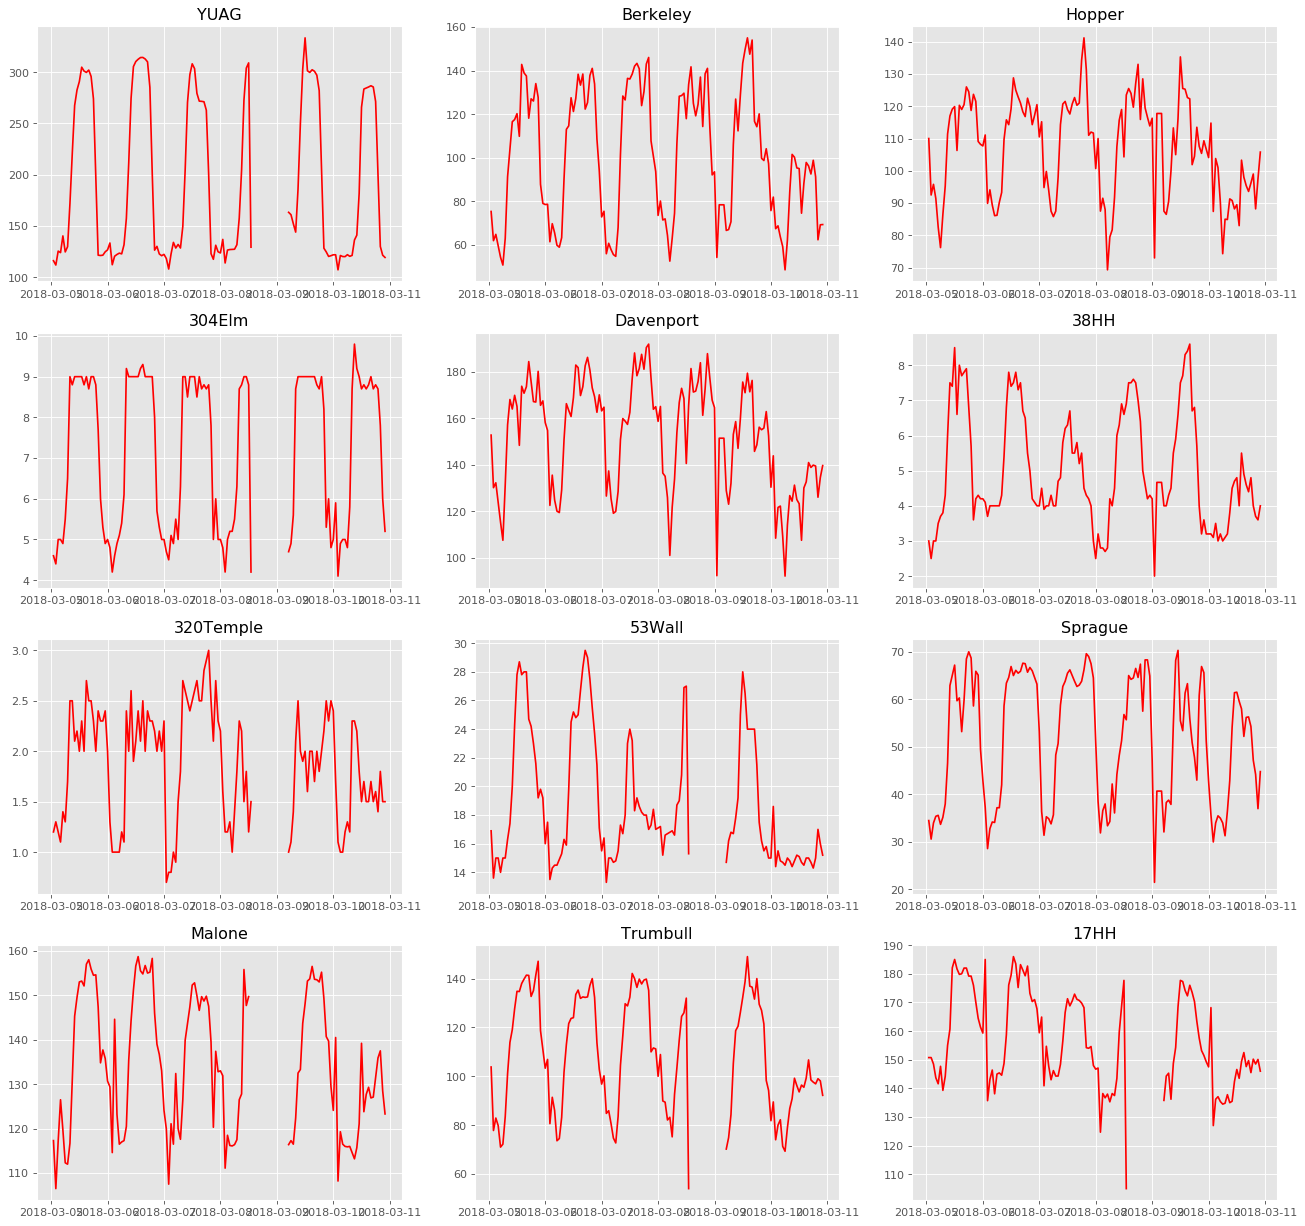

In [10]:
dense_energy = demand.copy(deep=True)

# interpolate gaps shorter than 6 hours
for k in dense_energy.columns:
    dense_energy[k] = fn.limited_impute(dense_energy[k],6)
    
fn.plot_all(dense_energy,'2018-03-05 01:00:00','2018-03-10 23:00:00')

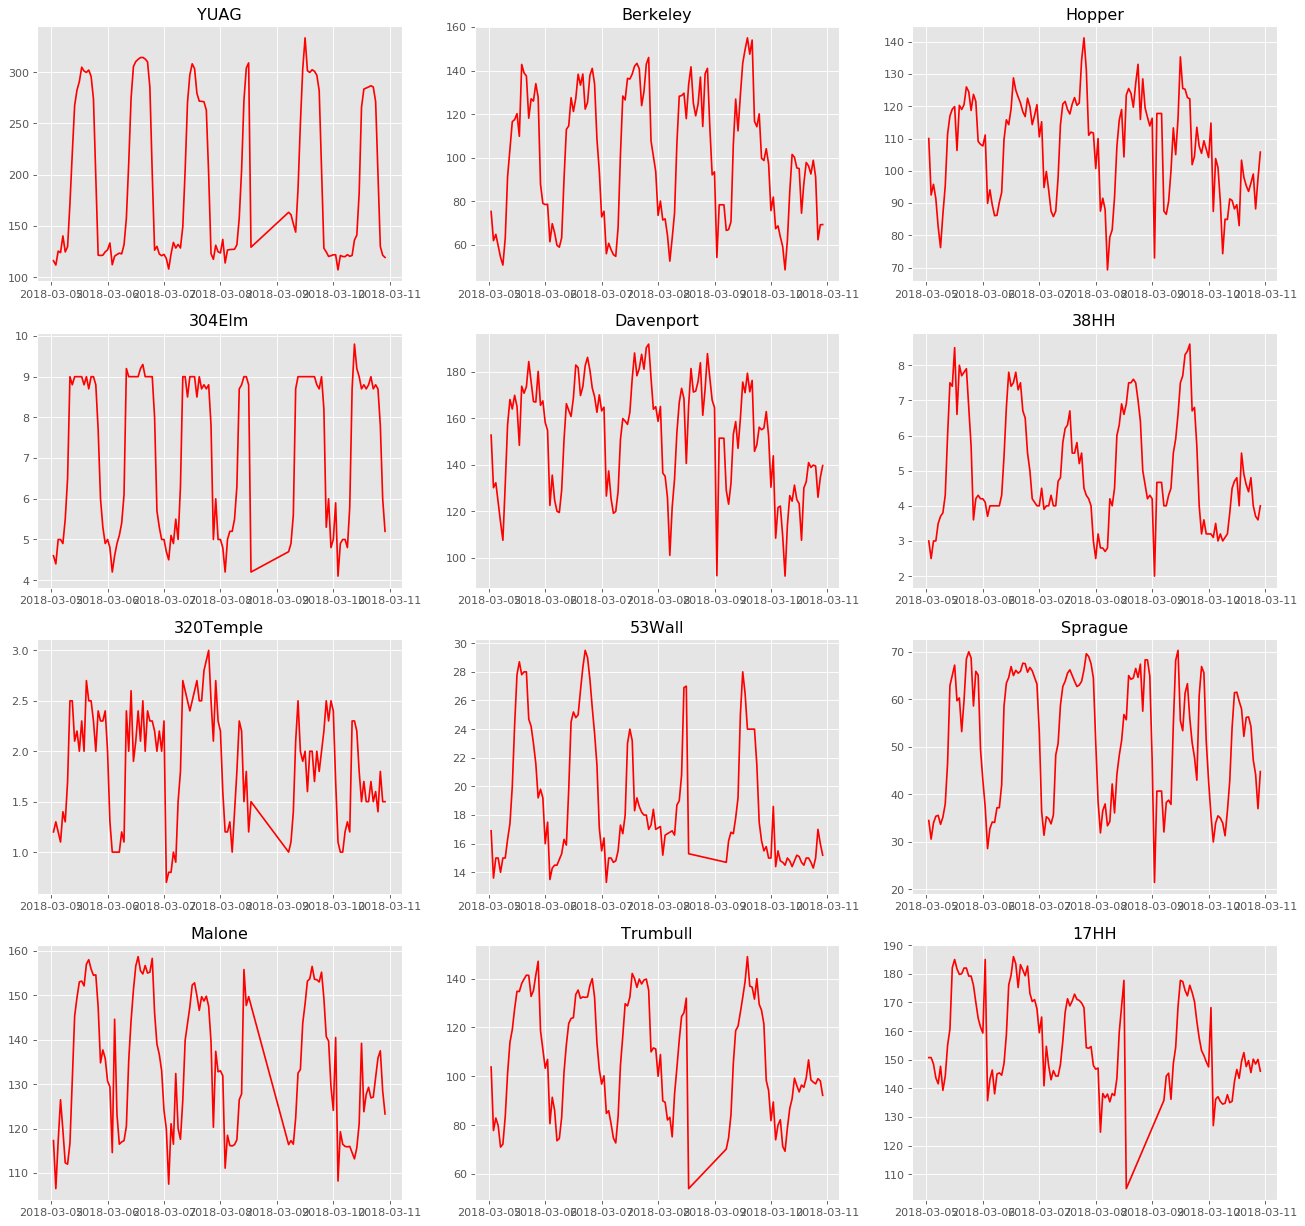

In [11]:
# interpolate gaps longer than 6 hours, linear for now, to be replaced by squared-sinusoidal
dense_energy.interpolate(method='linear',inplace=True)

fn.plot_all(dense_energy,'2018-03-05 01:00:00','2018-03-10 23:00:00')

In [12]:
# replace head for final export
dense_energy.iloc[0:4] = demand_head

# export to csv
dense_energy.round(1).to_csv('energy_clean.csv')

# unused code below

In [13]:
# # this cell removes all consumption values BELOW first value

# # creates dataframe of repeated minimum (first) values, pretty workaroundy
# raw_mins = raw.copy(deep=True)
# raw_mins.loc[:,:] = raw.loc['2018-01-01 00:00:00'].values

# # sets all violating values to NaN
# raw = raw.where(raw >= raw_mins)

# # this unused line was an attempt to find outliers using std ranges
# # raw = raw.where(raw > raw.median() - 2*raw.std()).where(raw < raw.median() + 2*raw.std())

# raw.isnull().sum()

In [14]:
# trying to plot daily average curves for buildings... matplotlib might support this somehow or i can write a fn

# raw = raw.iloc[:,[0]]

# raw['day'] = raw.index.day
# raw['hour'] = raw.index.hour

# raw_by_day = raw.resample('h').mean()
# raw_by_day = raw_by_day.set_index(['day','hour']).unstack('day')
# raw_by_day

In [15]:
# OLD ATTEMPT to find outliers using tuner values

# comp = demand.take([1], axis=1)
# comp['rolling'] = comp.loc[:,'Berkeley'].rolling(4,min_periods=1).median()
# # demand.rolling(4,min_periods=1).median()*0.5

# comp['rollmin'] = comp.loc[:,'Berkeley'].rolling(8,min_periods=6).min()

# # fn.plot_all(comp,'2018-03-14 00:00:00','2018-06-20 00:00:00')

# fn.plot_feature(comp,'rollmin','2018-01-02 00:00:00','2018-07-25 00:00:00')

# comp['rollmin'].median()-comp['rollmin'].std()

# max_tuner = 1 # here i want higher values clipping more points
# min_tuner = 1

# # demand.std()/demand.median() # here high values indicate volatile, 

# demand = demand.where(demand > demand.rolling(8,min_periods=4).min() - (min_tuner - demand.std()/demand.median()))
                      
# demand = demand.where(demand < demand.rolling(8,min_periods=4).max() + (max_tuner - demand.std()/demand.median()))

# fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
# demand.isnull().sum()

In [16]:
# iterative (bad performance) solution for single spikes, could work as supplement

# k='YUAG'

# for i in range(len(demand)-1):
#     if (abs(demand.pct_change()[k][i]) > 0.5) & (abs(demand.pct_change()[k][i+1]) > 0.5):
#         demand[k][i] = np.NaN

# fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
# demand.isnull().sum()

